# Crimes in CDMX / *Delitos en CDMX*

This work intents to analyze crimes in three faces / *Este trabajo intenta analizar los delitos en tres partes*:  
- Top crimes types / *Principales tipos de delitos*  
- Top neighborhoods per crimes type / *Principales colonias por tipo de delito*
- Neighborhoods clusters per crime rate / *Grupos de colonias por índice de delitos*

## Table of Contents / *Tabla de contenidos*

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Installing Tools / *Instalando Herramientas*](#0)<br>
2. [Downloading and Preparing Data / *Bajando y Preparando los Datos*](#2)<br>
3. [Analyzing the Data / *Analizando los Datos*](#4) <br>
4. [Map with Markers / *Mapa con Marcadores*](#6) <br>
</div>
<hr>

# 1. Installing Tools / *Instalando Herramientas*<a id="0"></a>

In [1]:
# Install Beautiful Soup
import sys
# Install Geopy, Folium and Beautiful Soup
!{sys.executable} -m pip install geopy
!{sys.executable} -m pip install folium
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install xlrd
print('Installation done')

     |████████████████████████████████| 102kB 2.3MB/s ta 0:00:011
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/99/45/d1/14954797e2a976083182c2e7da9b4e924509e59b6e5c661061
Successfully built geographiclib
     |████████████████████████████████| 102kB 2.6MB/s ta 0:00:011
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
     |████████████████████████████████| 112kB 3.1MB/s eta 0:00:01
Installation done


In [2]:
# Install tools
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from sklearn.cluster import KMeans
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from IPython.display import Image 
from IPython.core.display import HTML 
from botocore.client import Config

import types
import ibm_boto3
import pandas as pd
import numpy as np
import requests
import os
import codecs
import requests # library to handle requests
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import json # library to handle JSON files
import folium # map rendering library

print('Tools imported.')

Tools imported.


# 2. Downloading and Preparing Data / *Bajando y Preparando los Datos*<a id="2"></a>

#### 2.1 Import crimes files and load files of neighborhoods and crimes / *Importar archivo de delitos y cargar archivos de colonias y delitos*

In [3]:
# Import the csv file of delitos
delitoscdmx = pd.read_excel('delitoscdmx.xlsx')
delitoscdmx.head()

Year  Month  Day                                              crime  \
0  2018      7   11  ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VI...   
1  2017     11   27                                             FRAUDE   
2  2017      5   31  ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VI...   
3  2019      1   16                            USURPACIÓN DE IDENTIDAD   
4  2019      7   19                         PORTACION DE ARMA DE FUEGO   

                  crimeID         borough neighborhood  longitude   latitude  
0  DELITO DE BAJO IMPACTO  MIGUEL HIDALGO  10 DE ABRIL -99.206127  19.447899  
1  DELITO DE BAJO IMPACTO  MIGUEL HIDALGO  10 DE ABRIL -99.206129  19.447952  
2  DELITO DE BAJO IMPACTO  MIGUEL HIDALGO  10 DE ABRIL -99.206199  19.447906  
3  DELITO DE BAJO IMPACTO  MIGUEL HIDALGO  10 DE ABRIL -99.206206  19.447911  
4  DELITO DE BAJO IMPACTO  MIGUEL HIDALGO  10 DE ABRIL -99.206210  19.447863

In [4]:
# Check the delitos entries
n_entries = delitoscdmx.shape[0]
print(f'There are {n_entries} entries in the delitoscdmx dataframe')

There are 797040 entries in the delitoscdmx dataframe


In [5]:
delitoscdmx = delitoscdmx.replace(to_replace='ALVARO OBREGON', value='AO')
delitoscdmx = delitoscdmx.replace(to_replace='AZCAPOTZALCO', value='AZ')
delitoscdmx = delitoscdmx.replace(to_replace='BENITO JUAREZ', value='BJ')
delitoscdmx = delitoscdmx.replace(to_replace='COYOACAN', value='COY')
delitoscdmx = delitoscdmx.replace(to_replace='CUAJIMALPA DE MORELOS', value='CUJ')
delitoscdmx = delitoscdmx.replace(to_replace='CUAUHTEMOC', value='CUA')
delitoscdmx = delitoscdmx.replace(to_replace='GUSTAVO A MADERO', value='GAM')
delitoscdmx = delitoscdmx.replace(to_replace='IZTACALCO', value='IZC')
delitoscdmx = delitoscdmx.replace(to_replace='IZTAPALAPA', value='IZT')
delitoscdmx = delitoscdmx.replace(to_replace='LA MAGDALENA CONTRERAS', value='MC')
delitoscdmx = delitoscdmx.replace(to_replace='MIGUEL HIDALGO', value='MH')
delitoscdmx = delitoscdmx.replace(to_replace='MILPA ALTA', value='MA')
delitoscdmx = delitoscdmx.replace(to_replace='TLAHUAC', value='TLH')
delitoscdmx = delitoscdmx.replace(to_replace='TLALPAN', value='TLA')
delitoscdmx = delitoscdmx.replace(to_replace='VENUSTIANO CARRANZA', value='VC')
delitoscdmx = delitoscdmx.replace(to_replace='XOCHIMILCO', value='XCH')

In [7]:
delitoscdmx.groupby('borough')['borough'].count()

borough
AO      52713
AZ      39838
BJ      71093
COY     54201
CUA    129523
CUJ     11512
GAM     79142
IZC     34780
IZT    118435
MA       5124
MC      12221
MH      53999
TLA     46236
TLH     17765
VC      45757
XCH     24701
Name: borough, dtype: int64

In [9]:
# Joining the neighborhood 
delitoscdmx['neighborhood'] = delitoscdmx[['neighborhood', 'borough']].apply(lambda x: ','.join(x.fillna('').map(str)), axis=1)
delitoscdmx.head()

Year  Month  Day                                              crime  \
0  2018      7   11  ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VI...   
1  2017     11   27                                             FRAUDE   
2  2017      5   31  ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VI...   
3  2019      1   16                            USURPACIÓN DE IDENTIDAD   
4  2019      7   19                         PORTACION DE ARMA DE FUEGO   

                  crimeID borough    neighborhood  longitude   latitude  
0  DELITO DE BAJO IMPACTO      MH  10 DE ABRIL,MH -99.206127  19.447899  
1  DELITO DE BAJO IMPACTO      MH  10 DE ABRIL,MH -99.206129  19.447952  
2  DELITO DE BAJO IMPACTO      MH  10 DE ABRIL,MH -99.206199  19.447906  
3  DELITO DE BAJO IMPACTO      MH  10 DE ABRIL,MH -99.206206  19.447911  
4  DELITO DE BAJO IMPACTO      MH  10 DE ABRIL,MH -99.206210  19.447863

In [10]:
# Check unique categories ID of the crimes 
n_unique = len(delitoscdmx['crimeID'].unique())
print(f'There are {n_unique} unique crime categories in this dataframe')
delitoscdmx.groupby('crimeID')['crimeID'].count().sort_values(ascending=False)

There are 16 unique crime categories in this dataframe


crimeID
DELITO DE BAJO IMPACTO                                     611868
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA        48754
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                        44788
HECHO NO DELICTIVO                                          43693
ROBO A NEGOCIO CON VIOLENCIA                                13535
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA        9286
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                        7681
HOMICIDIO DOLOSO                                             4021
LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO                3133
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA      3033
VIOLACIÓN                                                    2481
ROBO A CASA HABITACIÓN CON VIOLENCIA                         1932
ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA      1502
ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA                 772
ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA                      430
SE

In [11]:
# Check unique categories types of the crimes 
n_unique1 = len(delitoscdmx['crime'].unique())
print(f'There are {n_unique1} unique crime types in this dataframe')
delitoscdmx.groupby('crime')['crime'].count().sort_values(ascending=False)

There are 275 unique crime types in this dataframe


crime
VIOLENCIA FAMILIAR                                70401
ROBO A NEGOCIO SIN VIOLENCIA                      53684
ROBO DE OBJETOS                                   52424
FRAUDE                                            45708
ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA    43397
                                                  ...  
ROBO DE VEHICULO Y NOMINA CON VIOLENCIA               1
CONTRA LA LEY GENERAL DE EXPLOSIVOS                   1
DESACATO                                              1
UTILIZACION INDEBIDA DE LA VIA PUBLICA                1
VIOLACION Y ROBO DE VEHICULO                          1
Name: crime, Length: 275, dtype: int64

In [12]:
# Check crimes per year 
delitoscdmx.groupby('Year')['Year'].count().sort_values(ascending=False)

Year
2018    245387
2017    218619
2016    190250
2019    142764
2015        20
Name: Year, dtype: int64

In [13]:
# Create a dataframe for coloniascdmx geospatical
coloniascdmx = delitoscdmx.groupby('neighborhood').mean()
coloniascdmx.drop(columns =["Year","Month","Day"], inplace = True)
coloniascdmx = coloniascdmx.reset_index()
coloniascdmx.head()

neighborhood  longitude   latitude
0       10 DE ABRIL,MH -99.208339  19.448460
1        10 DE MAYO,VC -99.117641  19.433161
2  12 DE DICIEMBRE,IZT -99.100685  19.329177
3     15 DE AGOSTO,GAM -99.107685  19.484104
4  16 DE SEPTIEMBRE,MH -99.207518  19.401741

#### 2.2 Data Visualization / *Visualización de Datos*

In [14]:
# One hot Encone Crime Categories
crime_category_onehot = pd.get_dummies(delitoscdmx[['crimeID']], prefix="", prefix_sep="")
crime_category_onehot['neighborhood'] = delitoscdmx['neighborhood'] 
fixed_columns = [crime_category_onehot.columns[-1]] + list(crime_category_onehot.columns[:-1])
crime_category_onehot = crime_category_onehot[fixed_columns]
print(crime_category_onehot.shape)
crime_category_onehot.head()

(797040, 17)


neighborhood  DELITO DE BAJO IMPACTO  HECHO NO DELICTIVO  \
0  10 DE ABRIL,MH                       1                   0   
1  10 DE ABRIL,MH                       1                   0   
2  10 DE ABRIL,MH                       1                   0   
3  10 DE ABRIL,MH                       1                   0   
4  10 DE ABRIL,MH                       1                   0   

   HOMICIDIO DOLOSO  LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
0                 0                                              0   
1                 0                                              0   
2                 0                                              0   
3                 0                                              0   
4                 0                                              0   

   ROBO A CASA HABITACIÓN CON VIOLENCIA  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   

   ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   ROBO A NEGOCIO CON VIOLENCIA  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   ROBO A REPARTIDOR CON Y SIN VIOLENCIA  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   ROBO DE VEHÍCULO CON Y SIN VIOLENCIA  SECUESTRO  VIOLACIÓN  
0                                     0          0          0  
1                                     0          0          0  
2                                     0          0          0  
3                                     0          0          0  
4                                     0          0          0

In [15]:
# Amount of Crimes in Each Neigborhoods
crime_counts = crime_category_onehot.groupby('neighborhood').sum()
crime_counts.head()

DELITO DE BAJO IMPACTO  HECHO NO DELICTIVO  \
neighborhood                                                      
10 DE ABRIL,MH                         74.0                 3.0   
10 DE MAYO,VC                         219.0                23.0   
12 DE DICIEMBRE,IZT                    87.0                 1.0   
15 DE AGOSTO,GAM                      209.0                23.0   
16 DE SEPTIEMBRE,MH                   161.0                 7.0   

                     HOMICIDIO DOLOSO  \
neighborhood                            
10 DE ABRIL,MH                    0.0   
10 DE MAYO,VC                     0.0   
12 DE DICIEMBRE,IZT               1.0   
15 DE AGOSTO,GAM                  1.0   
16 DE SEPTIEMBRE,MH               0.0   

                     LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
neighborhood                                                         
10 DE ABRIL,MH                                                 0.0   
10 DE MAYO,VC                                                  3.0   
12 DE DICIEMBRE,IZT                                            0.0   
15 DE AGOSTO,GAM                                               2.0   
16 DE SEPTIEMBRE,MH                                            2.0   

                     ROBO A CASA HABITACIÓN CON VIOLENCIA  \
neighborhood                                                
10 DE ABRIL,MH                                        0.0   
10 DE MAYO,VC                                         0.0   
12 DE DICIEMBRE,IZT                                   0.0   
15 DE AGOSTO,GAM                                      2.0   
16 DE SEPTIEMBRE,MH                                   0.0   

                     ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
neighborhood                                                                   
10 DE ABRIL,MH                                                     0.0         
10 DE MAYO,VC                                                      0.0         
12 DE DICIEMBRE,IZT                                                0.0         
15 DE AGOSTO,GAM                                                   0.0         
16 DE SEPTIEMBRE,MH                                                0.0         

                     ROBO A NEGOCIO CON VIOLENCIA  \
neighborhood                                        
10 DE ABRIL,MH                                0.0   
10 DE MAYO,VC                                 0.0   
12 DE DICIEMBRE,IZT                           3.0   
15 DE AGOSTO,GAM                              2.0   
16 DE SEPTIEMBRE,MH                           0.0   

                     ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
neighborhood                                                                   
10 DE ABRIL,MH                                                     1.0         
10 DE MAYO,VC                                                      1.0         
12 DE DICIEMBRE,IZT                                                0.0         
15 DE AGOSTO,GAM                                                   7.0         
16 DE SEPTIEMBRE,MH                                                0.0         

                     ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
neighborhood                                                         
10 DE ABRIL,MH                                                 0.0   
10 DE MAYO,VC                                                  0.0   
12 DE DICIEMBRE,IZT                                            0.0   
15 DE AGOSTO,GAM                                               0.0   
16 DE SEPTIEMBRE,MH                                            1.0   

                     ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
neighborhood                                                                 
10 DE ABRIL,MH                                                     0.0       
10 DE MAYO,VC                                                      7.0       
12 DE DICIEMBRE,IZT                            

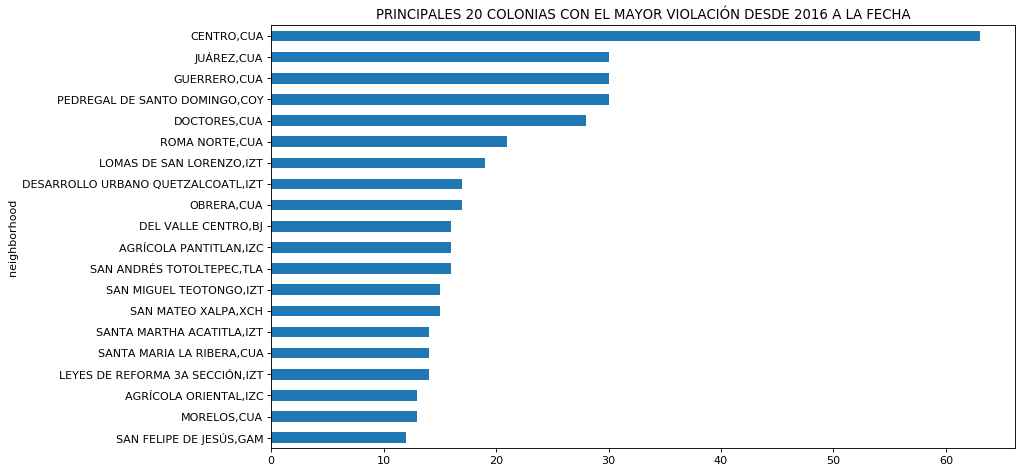

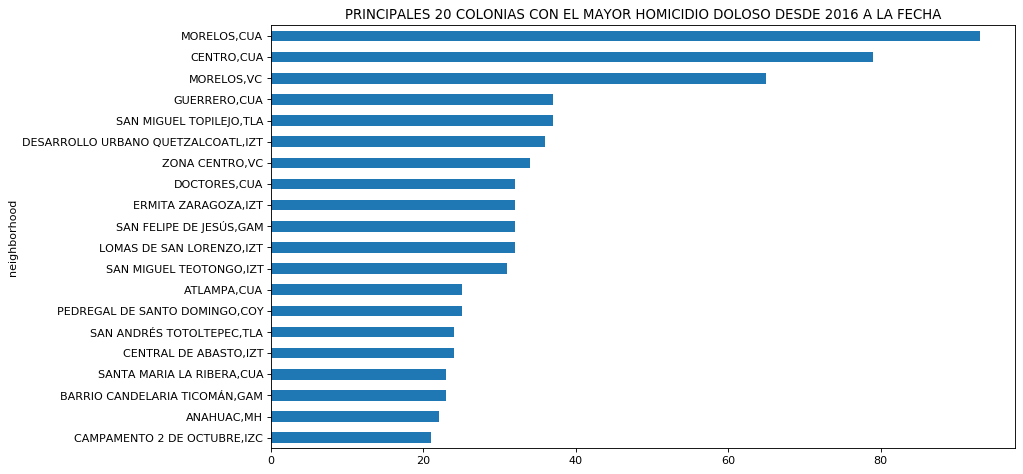

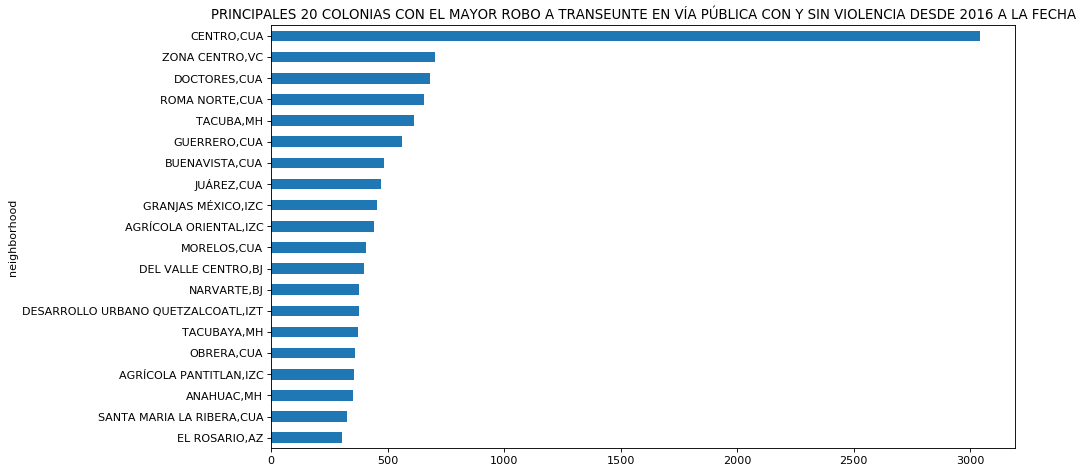

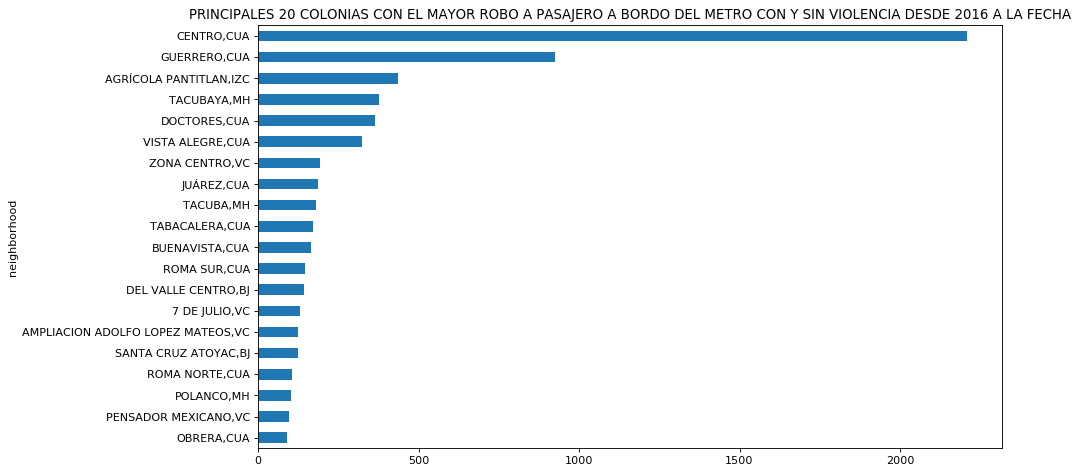

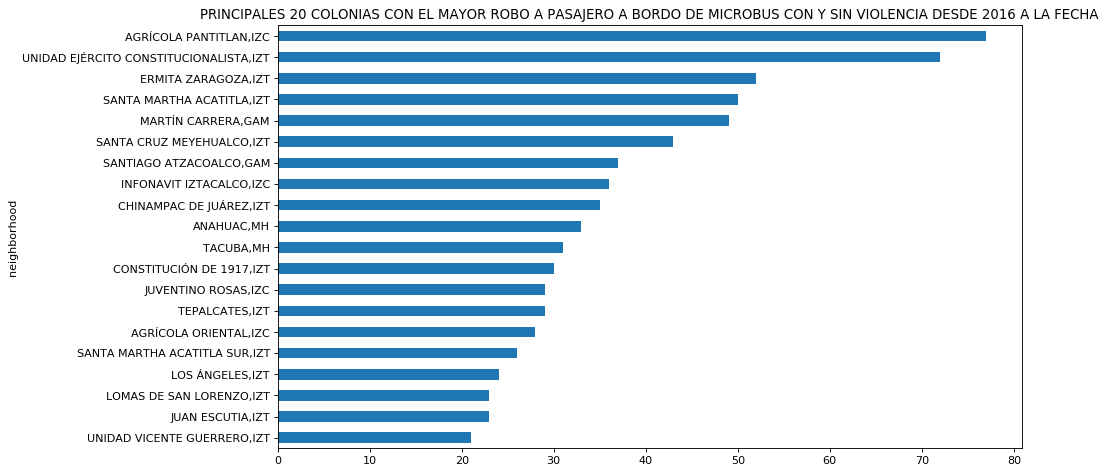

In [20]:
# Top 20 Neighborhood Plots for Violación y Secuestro
plot_categories = ['VIOLACIÓN', 'HOMICIDIO DOLOSO', 'ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA','ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA',
                  'ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA']
n = 20
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'PRINCIPALES {n} COLONIAS CON EL MAYOR {category} DESDE 2016 A LA FECHA')
    top_category_neighborhoods = crime_counts[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods = top_category_neighborhoods.sort_values(ascending=True)
    top_category_neighborhoods.plot.barh(y=category, rot=0)

---

# 3. Analyzing the Data / *Analizando los Datos*<a id="4"></a>

#### 3.1 Separating Crimes per Year / *Separando los Delitos por Año*

In [21]:
year19=['2019']
delitos2019 = delitoscdmx[delitoscdmx['Year'].isin(year19)]
print(delitos2019.shape)
delitos2019.head()

(142764, 9)


Year  Month  Day                                              crime  \
3   2019      1   16                            USURPACIÓN DE IDENTIDAD   
4   2019      7   19                         PORTACION DE ARMA DE FUEGO   
9   2019      6   10                            USURPACIÓN DE IDENTIDAD   
10  2019      3   25  LESIONES CULPOSAS POR TRANSITO VEHICULAR EN CO...   
16  2019      3   11        ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO   

                   crimeID borough    neighborhood  longitude   latitude  
3   DELITO DE BAJO IMPACTO      MH  10 DE ABRIL,MH -99.206206  19.447911  
4   DELITO DE BAJO IMPACTO      MH  10 DE ABRIL,MH -99.206210  19.447863  
9   DELITO DE BAJO IMPACTO      MH  10 DE ABRIL,MH -99.206405  19.447716  
10  DELITO DE BAJO IMPACTO      MH  10 DE ABRIL,MH -99.206431  19.447728  
16  DELITO DE BAJO IMPACTO      MH  10 DE ABRIL,MH -99.206508  19.447701

In [22]:
# Create a dataframe which count crimesID
crime_category_onehot19 = pd.get_dummies(delitos2019[['crimeID']], prefix="", prefix_sep="")
crime_category_onehot19['neighborhood'] = delitos2019['neighborhood'] 
fixed_columns19 = [crime_category_onehot19.columns[-1]] + list(crime_category_onehot19.columns[:-1])
crime_category_onehot19 = crime_category_onehot19[fixed_columns19]

# Amount of Crimes in Each Neigborhoods
crime_counts19 = crime_category_onehot19.groupby('neighborhood').sum()

# Drop Delitos de Bajo Impacto y Hecho No Delictivo
crime_counts19.drop(columns =["DELITO DE BAJO IMPACTO","HECHO NO DELICTIVO"], inplace = True)

# Add a new column with interests counts value
crime_counts19 = crime_counts19.replace(to_replace=0, value=np.nan)
crime_counts19['CRIMENES'] = crime_counts19.sum(axis='columns')
crime_counts19 = crime_counts19.replace(to_replace=np.nan, value=0)

# Drop Neighborhoods without crimes
crime_counts19 = crime_counts19[(crime_counts19[['CRIMENES']] != 0).all(axis=1)]

# Check the results
crime_counts19.head()

HOMICIDIO DOLOSO  \
neighborhood                            
10 DE ABRIL,MH                    0.0   
10 DE MAYO,VC                     0.0   
12 DE DICIEMBRE,IZT               0.0   
15 DE AGOSTO,GAM                  0.0   
16 DE SEPTIEMBRE,MH               0.0   

                     LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
neighborhood                                                         
10 DE ABRIL,MH                                                 0.0   
10 DE MAYO,VC                                                  0.0   
12 DE DICIEMBRE,IZT                                            0.0   
15 DE AGOSTO,GAM                                               1.0   
16 DE SEPTIEMBRE,MH                                            0.0   

                     ROBO A CASA HABITACIÓN CON VIOLENCIA  \
neighborhood                                                
10 DE ABRIL,MH                                        0.0   
10 DE MAYO,VC                                         0.0   
12 DE DICIEMBRE,IZT                                   0.0   
15 DE AGOSTO,GAM                                      0.0   
16 DE SEPTIEMBRE,MH                                   0.0   

                     ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
neighborhood                                                                   
10 DE ABRIL,MH                                                     0.0         
10 DE MAYO,VC                                                      0.0         
12 DE DICIEMBRE,IZT                                                0.0         
15 DE AGOSTO,GAM                                                   0.0         
16 DE SEPTIEMBRE,MH                                                0.0         

                     ROBO A NEGOCIO CON VIOLENCIA  \
neighborhood                                        
10 DE ABRIL,MH                                0.0   
10 DE MAYO,VC                                 0.0   
12 DE DICIEMBRE,IZT                           1.0   
15 DE AGOSTO,GAM                              1.0   
16 DE SEPTIEMBRE,MH                           0.0   

                     ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
neighborhood                                                                   
10 DE ABRIL,MH                                                     0.0         
10 DE MAYO,VC                                                      0.0         
12 DE DICIEMBRE,IZT                                                0.0         
15 DE AGOSTO,GAM                                                   0.0         
16 DE SEPTIEMBRE,MH                                                0.0         

                     ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
neighborhood                                                         
10 DE ABRIL,MH                                                 0.0   
10 DE MAYO,VC                                                  0.0   
12 DE DICIEMBRE,IZT                                            0.0   
15 DE AGOSTO,GAM                                               0.0   
16 DE SEPTIEMBRE,MH                                            0.0   

                     ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
neighborhood                                                                 
10 DE ABRIL,MH                                                     0.0       
10 DE MAYO,VC                                                      1.0       
12 DE DICIEMBRE,IZT                                                0.0       
15 DE AGOSTO,GAM                                                   7.0       
16 DE SEPTIEMBRE,MH                                                0.0       

                     ROBO A REPARTIDOR CON Y SIN VIOLENCIA  \
neighborhood                                                 
10 DE ABRIL,MH                                         0.0   
10 DE MAYO,VC                                          2.0   
12 DE DICIEMBRE,IZT               

#### 3.2 Checking the Top Neighborhoods with Crimes / *Revisando las Principales Colonias con Delitos*

In [24]:
# Make top 20
crime_counts19b = crime_counts19
crime_counts19b = crime_counts19b.replace(to_replace=np.nan, value=0).reset_index()
crimes = crime_counts19b[['neighborhood', 'CRIMENES']].copy()
crimes['CRIMENES'] = crimes['CRIMENES'].astype(int)
crimes.set_index('neighborhood', inplace=True)
crimes.sort_values(by='CRIMENES',ascending=True,inplace=True)
df_top20=crimes['CRIMENES'].tail(20)
df_top20

neighborhood
POLANCO,MH                             155
SANTA MARIA LA RIBERA,CUA              156
PORTALES SUR,BJ                        169
BUENAVISTA,CUA                         172
TACUBAYA,MH                            186
JUÁREZ,CUA                             192
CENTRAL DE ABASTO,IZT                  197
NARVARTE,BJ                            198
GRANJAS MÉXICO,IZC                     222
DEL VALLE CENTRO,BJ                    231
ROMA NORTE,CUA                         232
DESARROLLO URBANO QUETZALCOATL,IZT     250
ZONA CENTRO,VC                         251
ANAHUAC,MH                             259
TACUBA,MH                              271
GUERRERO,CUA                           298
DOCTORES,CUA                           299
AGRÍCOLA PANTITLAN,IZC                 374
AGRÍCOLA ORIENTAL,IZC                  378
CENTRO,CUA                            1038
Name: CRIMENES, dtype: int64

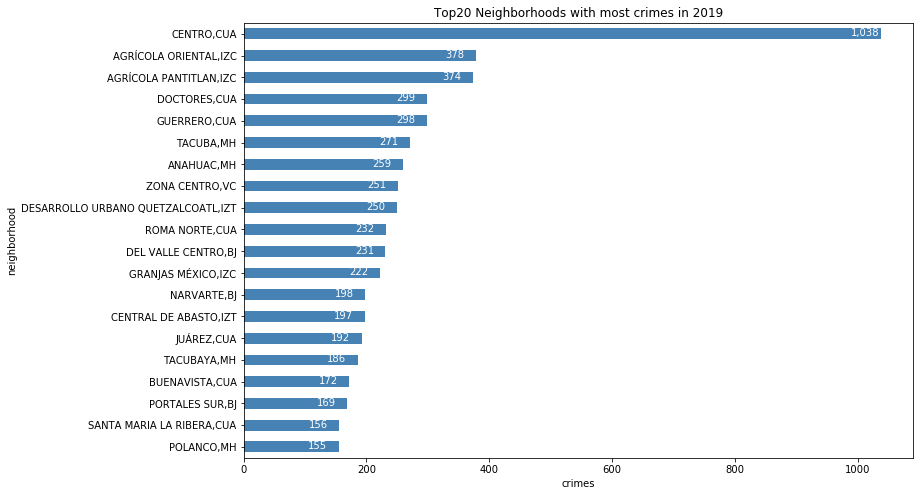

In [25]:
# Make an horizontal bar chart with top 20 neighborhoods with most crimes 
df_top20.plot(kind='barh', figsize=(12,8), color='steelblue')
plt.xlabel('crimes')
plt.title('Top20 Neighborhoods with most crimes in 2019')
for index, value in enumerate(df_top20): 
    label = format(int(value), ',')
    plt.annotate(label, xy=(value - 50, index - 0.10), color='white')
plt.show()

#### 3.3 Checking Crimes in Other Years / *Revisando Delitos de Otros Años*

In [26]:
# Creating data sets for the other years
year18=['2018']
year17=['2017']
year16=['2016', '2015']
delitos2018 = delitoscdmx[delitoscdmx['Year'].isin(year18)]
delitos2017 = delitoscdmx[delitoscdmx['Year'].isin(year17)]
delitos2016 = delitoscdmx[delitoscdmx['Year'].isin(year16)]
print('Cantidad de delitos en 2019: ',delitos2019.shape[0])
print('Cantidad de delitos en 2018: ',delitos2018.shape[0])
print('Cantidad de delitos en 2017: ',delitos2017.shape[0])
print('Cantidad de delitos en 2016: ',delitos2016.shape[0])

Cantidad de delitos en 2019:  142764
Cantidad de delitos en 2018:  245387
Cantidad de delitos en 2017:  218619
Cantidad de delitos en 2016:  190270


In [27]:
# Create a dataframe which count crimesID
crime_category_onehot18 = pd.get_dummies(delitos2018[['crimeID']], prefix="", prefix_sep="")
crime_category_onehot18['neighborhood'] = delitos2018['neighborhood'] 
fixed_columns18 = [crime_category_onehot18.columns[-1]] + list(crime_category_onehot18.columns[:-1])
crime_category_onehot18 = crime_category_onehot18[fixed_columns18]

# Amount of Crimes in Each Neigborhoods
crime_counts18 = crime_category_onehot18.groupby('neighborhood').sum()

# Drop Delitos de Bajo Impacto y Hecho No Delictivo
crime_counts18.drop(columns =["DELITO DE BAJO IMPACTO","HECHO NO DELICTIVO"], inplace = True)

# Add a new column with interests counts value
crime_counts18 = crime_counts18.replace(to_replace=0, value=np.nan)
crime_counts18['CRIMENES'] = crime_counts18.sum(axis='columns')
crime_counts18 = crime_counts18.replace(to_replace=np.nan, value=0)

# Drop Neighborhoods without crimes
crime_counts18 = crime_counts18[(crime_counts18[['CRIMENES']] != 0).all(axis=1)]

# Check the results
crime_counts18.head()

HOMICIDIO DOLOSO  \
neighborhood                            
10 DE ABRIL,MH                    0.0   
10 DE MAYO,VC                     0.0   
12 DE DICIEMBRE,IZT               0.0   
15 DE AGOSTO,GAM                  0.0   
16 DE SEPTIEMBRE,MH               0.0   

                     LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
neighborhood                                                         
10 DE ABRIL,MH                                                 0.0   
10 DE MAYO,VC                                                  0.0   
12 DE DICIEMBRE,IZT                                            0.0   
15 DE AGOSTO,GAM                                               0.0   
16 DE SEPTIEMBRE,MH                                            0.0   

                     ROBO A CASA HABITACIÓN CON VIOLENCIA  \
neighborhood                                                
10 DE ABRIL,MH                                        0.0   
10 DE MAYO,VC                                         0.0   
12 DE DICIEMBRE,IZT                                   0.0   
15 DE AGOSTO,GAM                                      1.0   
16 DE SEPTIEMBRE,MH                                   0.0   

                     ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
neighborhood                                                                   
10 DE ABRIL,MH                                                     0.0         
10 DE MAYO,VC                                                      0.0         
12 DE DICIEMBRE,IZT                                                0.0         
15 DE AGOSTO,GAM                                                   0.0         
16 DE SEPTIEMBRE,MH                                                0.0         

                     ROBO A NEGOCIO CON VIOLENCIA  \
neighborhood                                        
10 DE ABRIL,MH                                0.0   
10 DE MAYO,VC                                 0.0   
12 DE DICIEMBRE,IZT                           0.0   
15 DE AGOSTO,GAM                              0.0   
16 DE SEPTIEMBRE,MH                           0.0   

                     ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
neighborhood                                                                   
10 DE ABRIL,MH                                                     0.0         
10 DE MAYO,VC                                                      0.0         
12 DE DICIEMBRE,IZT                                                0.0         
15 DE AGOSTO,GAM                                                   1.0         
16 DE SEPTIEMBRE,MH                                                0.0         

                     ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
neighborhood                                                         
10 DE ABRIL,MH                                                 0.0   
10 DE MAYO,VC                                                  0.0   
12 DE DICIEMBRE,IZT                                            0.0   
15 DE AGOSTO,GAM                                               0.0   
16 DE SEPTIEMBRE,MH                                            0.0   

                     ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
neighborhood                                                                 
10 DE ABRIL,MH                                                     0.0       
10 DE MAYO,VC                                                      4.0       
12 DE DICIEMBRE,IZT                                                0.0       
15 DE AGOSTO,GAM                                                   9.0       
16 DE SEPTIEMBRE,MH                                                0.0       

                     ROBO A REPARTIDOR CON Y SIN VIOLENCIA  \
neighborhood                                                 
10 DE ABRIL,MH                                         0.0   
10 DE MAYO,VC                                          0.0   
12 DE DICIEMBRE,IZT               

In [28]:
# Create a dataframe which count crimesID
crime_category_onehot17 = pd.get_dummies(delitos2017[['crimeID']], prefix="", prefix_sep="")
crime_category_onehot17['neighborhood'] = delitos2017['neighborhood'] 
fixed_columns17 = [crime_category_onehot17.columns[-1]] + list(crime_category_onehot17.columns[:-1])
crime_category_onehot17 = crime_category_onehot17[fixed_columns17]

# Amount of Crimes in Each Neigborhoods
crime_counts17 = crime_category_onehot17.groupby('neighborhood').sum()

# Drop Delitos de Bajo Impacto y Hecho No Delictivo
crime_counts17.drop(columns =["DELITO DE BAJO IMPACTO","HECHO NO DELICTIVO"], inplace = True)

# Add a new column with interests counts value
crime_counts17 = crime_counts17.replace(to_replace=0, value=np.nan)
crime_counts17['CRIMENES'] = crime_counts17.sum(axis='columns')
crime_counts17 = crime_counts17.replace(to_replace=np.nan, value=0)

# Drop Neighborhoods without crimes
crime_counts17 = crime_counts17[(crime_counts17[['CRIMENES']] != 0).all(axis=1)]

# Check the results
crime_counts17.head()

HOMICIDIO DOLOSO  \
neighborhood                            
10 DE ABRIL,MH                    0.0   
10 DE MAYO,VC                     0.0   
12 DE DICIEMBRE,IZT               0.0   
15 DE AGOSTO,GAM                  1.0   
16 DE SEPTIEMBRE,MH               0.0   

                     LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
neighborhood                                                         
10 DE ABRIL,MH                                                 0.0   
10 DE MAYO,VC                                                  1.0   
12 DE DICIEMBRE,IZT                                            0.0   
15 DE AGOSTO,GAM                                               0.0   
16 DE SEPTIEMBRE,MH                                            2.0   

                     ROBO A CASA HABITACIÓN CON VIOLENCIA  \
neighborhood                                                
10 DE ABRIL,MH                                        0.0   
10 DE MAYO,VC                                         0.0   
12 DE DICIEMBRE,IZT                                   0.0   
15 DE AGOSTO,GAM                                      1.0   
16 DE SEPTIEMBRE,MH                                   0.0   

                     ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
neighborhood                                                                   
10 DE ABRIL,MH                                                     0.0         
10 DE MAYO,VC                                                      0.0         
12 DE DICIEMBRE,IZT                                                0.0         
15 DE AGOSTO,GAM                                                   0.0         
16 DE SEPTIEMBRE,MH                                                0.0         

                     ROBO A NEGOCIO CON VIOLENCIA  \
neighborhood                                        
10 DE ABRIL,MH                                0.0   
10 DE MAYO,VC                                 0.0   
12 DE DICIEMBRE,IZT                           1.0   
15 DE AGOSTO,GAM                              1.0   
16 DE SEPTIEMBRE,MH                           0.0   

                     ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
neighborhood                                                                   
10 DE ABRIL,MH                                                     1.0         
10 DE MAYO,VC                                                      1.0         
12 DE DICIEMBRE,IZT                                                0.0         
15 DE AGOSTO,GAM                                                   2.0         
16 DE SEPTIEMBRE,MH                                                0.0         

                     ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
neighborhood                                                         
10 DE ABRIL,MH                                                 0.0   
10 DE MAYO,VC                                                  0.0   
12 DE DICIEMBRE,IZT                                            0.0   
15 DE AGOSTO,GAM                                               0.0   
16 DE SEPTIEMBRE,MH                                            1.0   

                     ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
neighborhood                                                                 
10 DE ABRIL,MH                                                     0.0       
10 DE MAYO,VC                                                      2.0       
12 DE DICIEMBRE,IZT                                                0.0       
15 DE AGOSTO,GAM                                                   3.0       
16 DE SEPTIEMBRE,MH                                                0.0       

                     ROBO A REPARTIDOR CON Y SIN VIOLENCIA  \
neighborhood                                                 
10 DE ABRIL,MH                                         0.0   
10 DE MAYO,VC                                          0.0   
12 DE DICIEMBRE,IZT               

In [29]:
# Create a dataframe which count crimesID
crime_category_onehot16 = pd.get_dummies(delitos2016[['crimeID']], prefix="", prefix_sep="")
crime_category_onehot16['neighborhood'] = delitos2016['neighborhood'] 
fixed_columns16 = [crime_category_onehot16.columns[-1]] + list(crime_category_onehot16.columns[:-1])
crime_category_onehot16 = crime_category_onehot16[fixed_columns16]

# Amount of Crimes in Each Neigborhoods
crime_counts16 = crime_category_onehot16.groupby('neighborhood').sum()

# Drop Delitos de Bajo Impacto y Hecho No Delictivo
crime_counts16.drop(columns =["DELITO DE BAJO IMPACTO","HECHO NO DELICTIVO"], inplace = True)

# Add a new column with interests counts value
crime_counts16 = crime_counts16.replace(to_replace=0, value=np.nan)
crime_counts16['CRIMENES'] = crime_counts16.sum(axis='columns')
crime_counts16 = crime_counts16.replace(to_replace=np.nan, value=0)

# Drop Neighborhoods without crimes
crime_counts16 = crime_counts16[(crime_counts16[['CRIMENES']] != 0).all(axis=1)]

# Check the results
crime_counts16.head()

HOMICIDIO DOLOSO  \
neighborhood                            
10 DE ABRIL,MH                    0.0   
10 DE MAYO,VC                     0.0   
12 DE DICIEMBRE,IZT               1.0   
15 DE AGOSTO,GAM                  0.0   
16 DE SEPTIEMBRE,MH               0.0   

                     LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
neighborhood                                                         
10 DE ABRIL,MH                                                 0.0   
10 DE MAYO,VC                                                  2.0   
12 DE DICIEMBRE,IZT                                            0.0   
15 DE AGOSTO,GAM                                               1.0   
16 DE SEPTIEMBRE,MH                                            0.0   

                     ROBO A CASA HABITACIÓN CON VIOLENCIA  \
neighborhood                                                
10 DE ABRIL,MH                                        0.0   
10 DE MAYO,VC                                         0.0   
12 DE DICIEMBRE,IZT                                   0.0   
15 DE AGOSTO,GAM                                      0.0   
16 DE SEPTIEMBRE,MH                                   0.0   

                     ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
neighborhood                                                                   
10 DE ABRIL,MH                                                     0.0         
10 DE MAYO,VC                                                      0.0         
12 DE DICIEMBRE,IZT                                                0.0         
15 DE AGOSTO,GAM                                                   0.0         
16 DE SEPTIEMBRE,MH                                                0.0         

                     ROBO A NEGOCIO CON VIOLENCIA  \
neighborhood                                        
10 DE ABRIL,MH                                0.0   
10 DE MAYO,VC                                 0.0   
12 DE DICIEMBRE,IZT                           1.0   
15 DE AGOSTO,GAM                              0.0   
16 DE SEPTIEMBRE,MH                           0.0   

                     ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
neighborhood                                                                   
10 DE ABRIL,MH                                                     0.0         
10 DE MAYO,VC                                                      0.0         
12 DE DICIEMBRE,IZT                                                0.0         
15 DE AGOSTO,GAM                                                   4.0         
16 DE SEPTIEMBRE,MH                                                0.0         

                     ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
neighborhood                                                         
10 DE ABRIL,MH                                                 0.0   
10 DE MAYO,VC                                                  0.0   
12 DE DICIEMBRE,IZT                                            0.0   
15 DE AGOSTO,GAM                                               0.0   
16 DE SEPTIEMBRE,MH                                            0.0   

                     ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
neighborhood                                                                 
10 DE ABRIL,MH                                                     0.0       
10 DE MAYO,VC                                                      0.0       
12 DE DICIEMBRE,IZT                                                0.0       
15 DE AGOSTO,GAM                                                   1.0       
16 DE SEPTIEMBRE,MH                                                0.0       

                     ROBO A REPARTIDOR CON Y SIN VIOLENCIA  \
neighborhood                                                 
10 DE ABRIL,MH                                         0.0   
10 DE MAYO,VC                                          0.0   
12 DE DICIEMBRE,IZT               

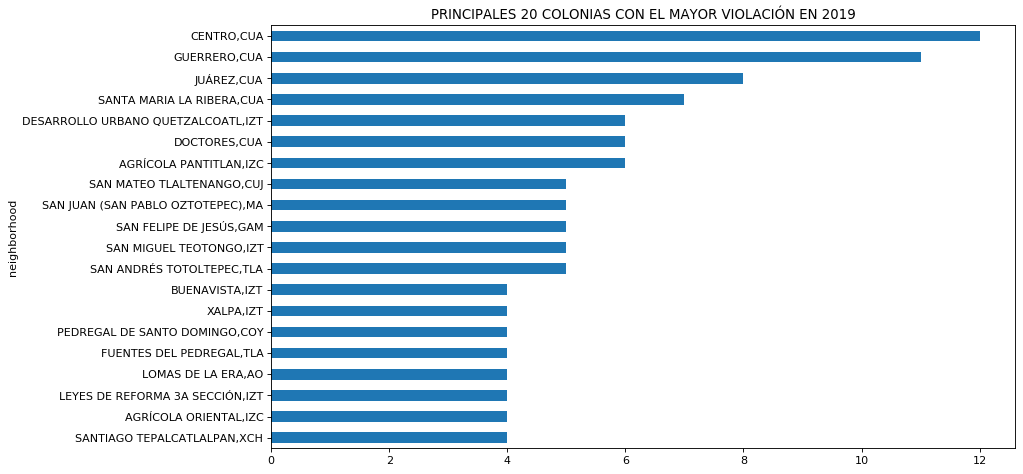

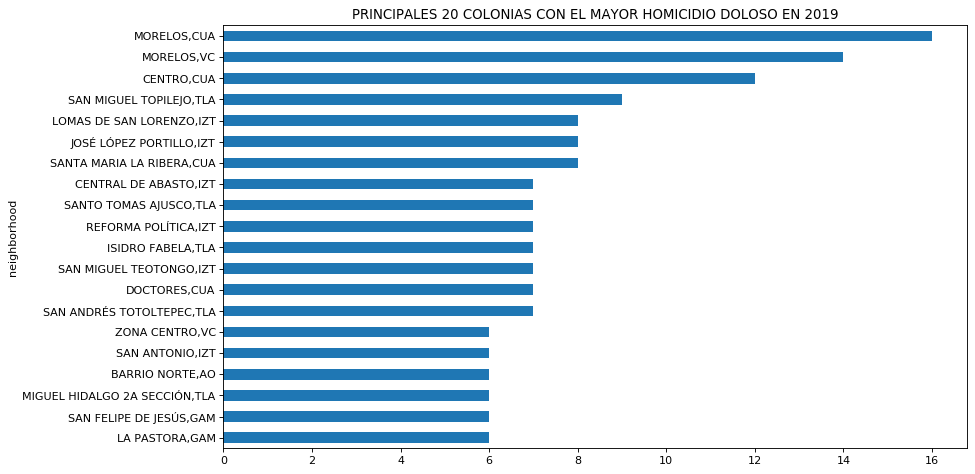

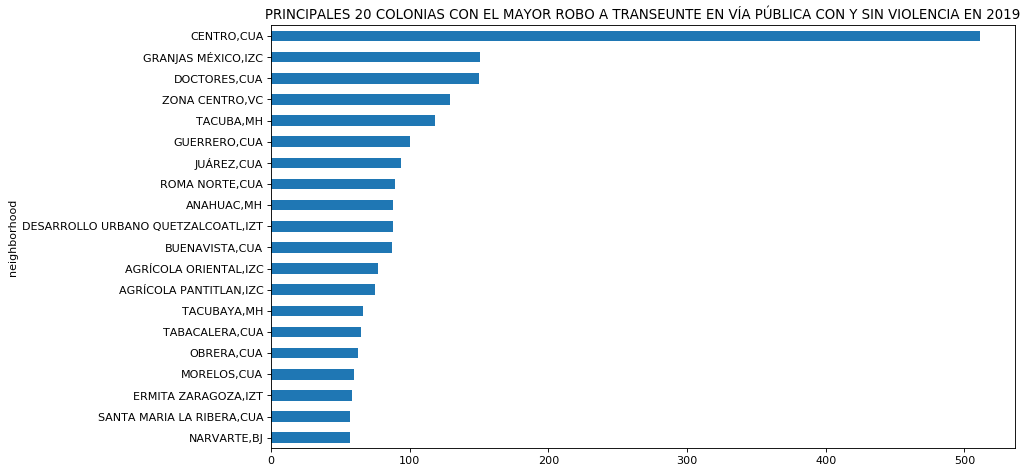

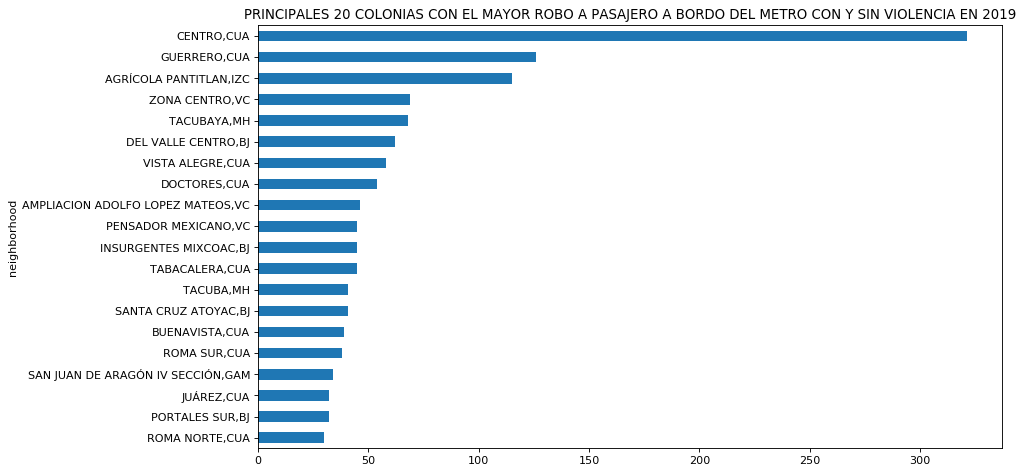

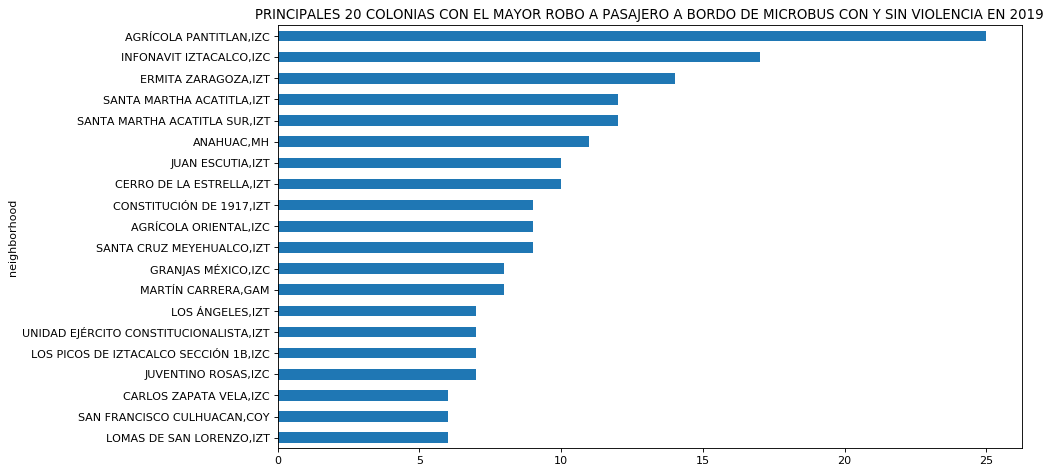

In [30]:
# Top 20 Neighborhood Plots for Violación y Secuestro 2019
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'PRINCIPALES {n} COLONIAS CON EL MAYOR {category} EN 2019')
    top_category_neighborhoods19 = crime_counts19[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods19 = top_category_neighborhoods19.sort_values(ascending=True)
    top_category_neighborhoods19.plot.barh(y=category, rot=0)

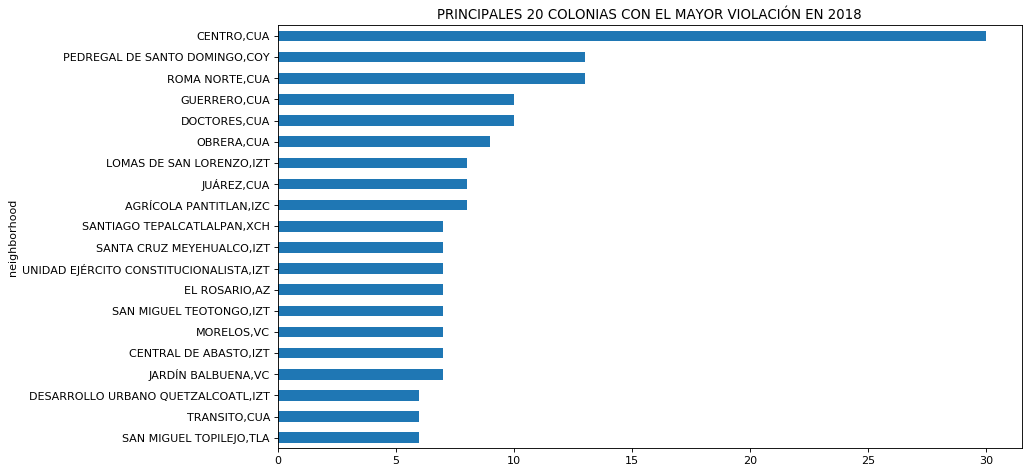

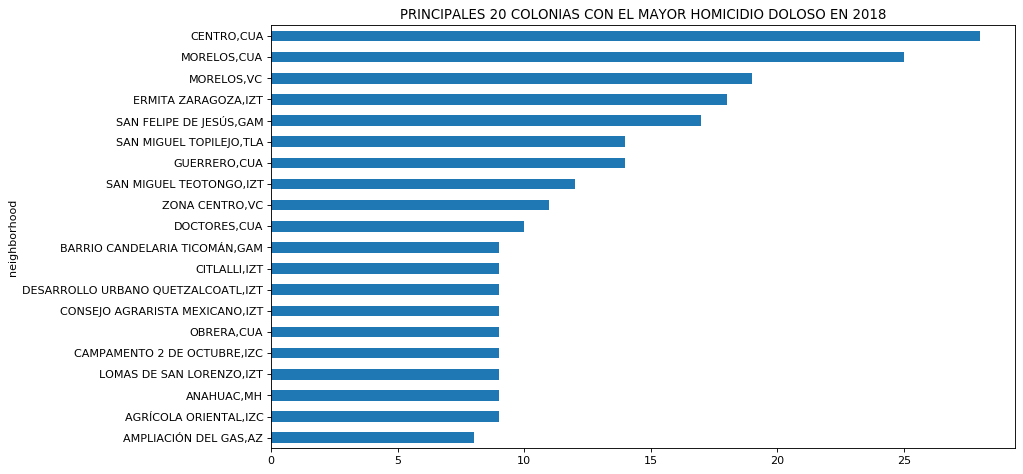

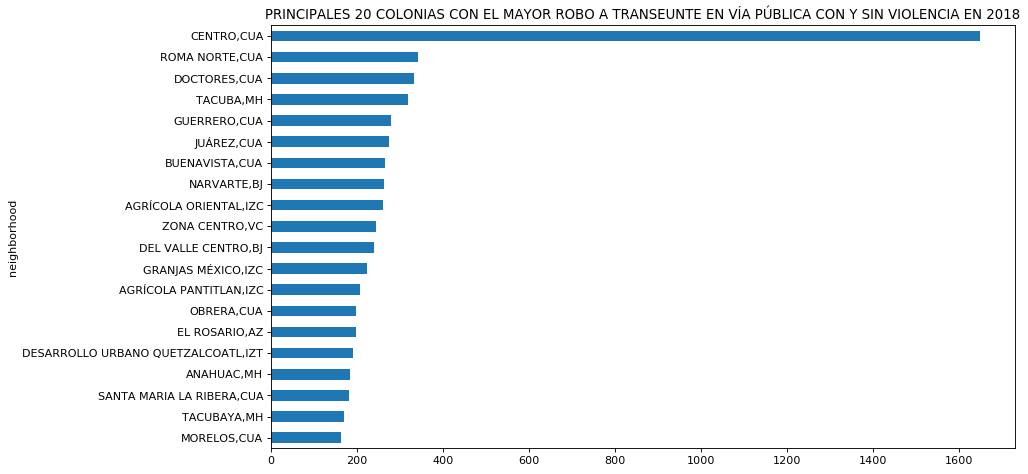

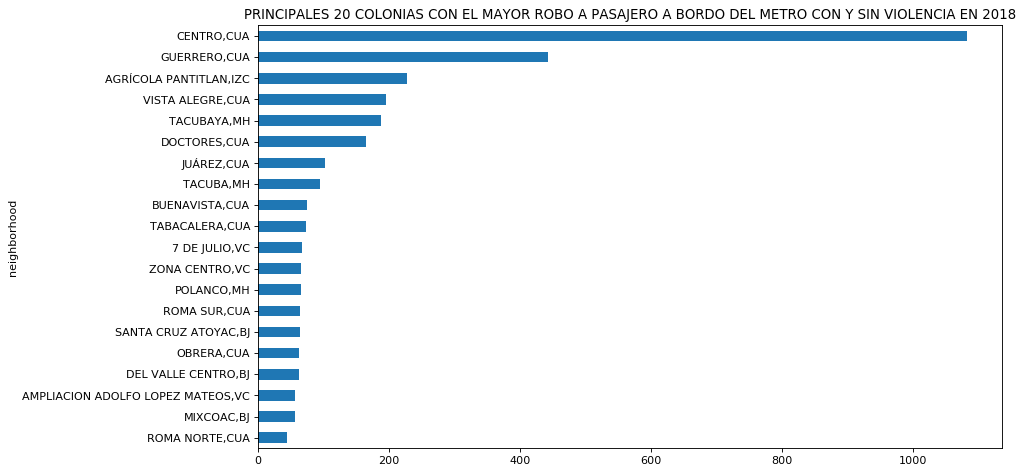

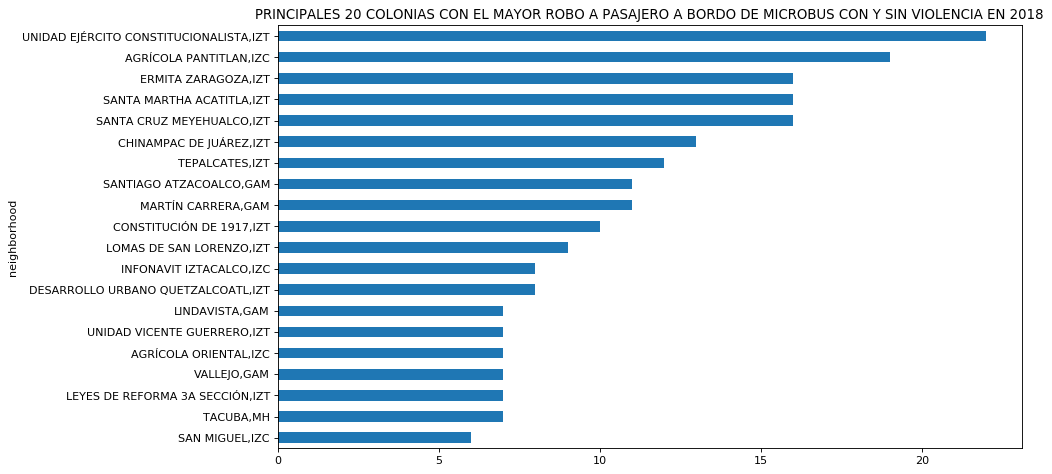

In [31]:
# Top 20 Neighborhood Plots for Violación y Secuestro 2018
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'PRINCIPALES {n} COLONIAS CON EL MAYOR {category} EN 2018')
    top_category_neighborhoods18 = crime_counts18[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods18 = top_category_neighborhoods18.sort_values(ascending=True)
    top_category_neighborhoods18.plot.barh(y=category, rot=0)

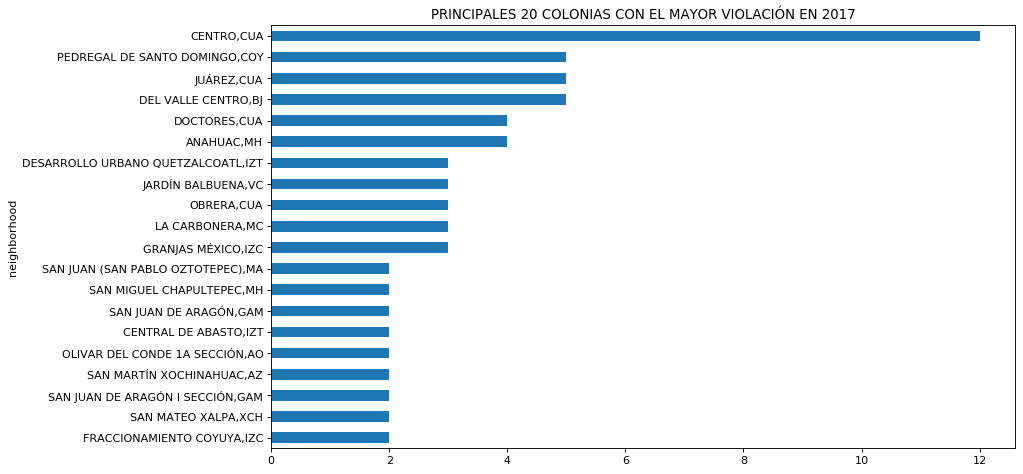

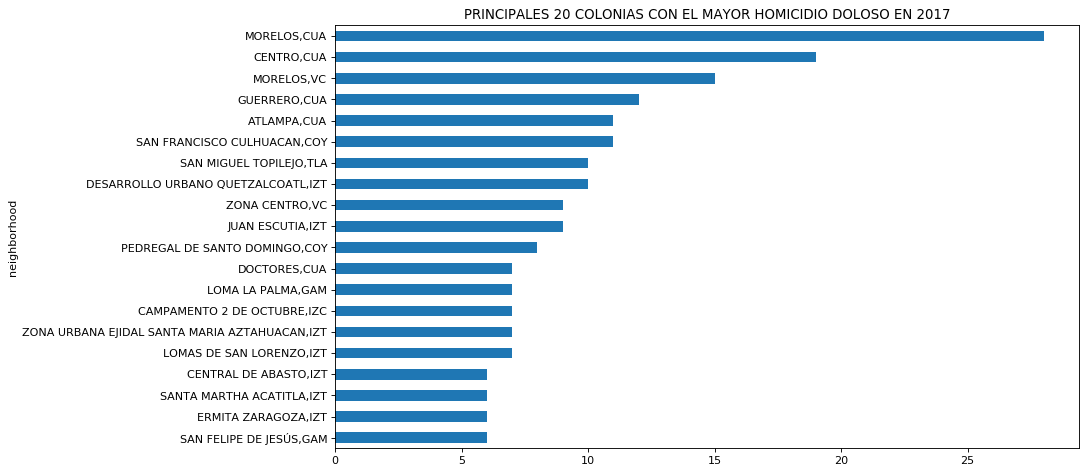

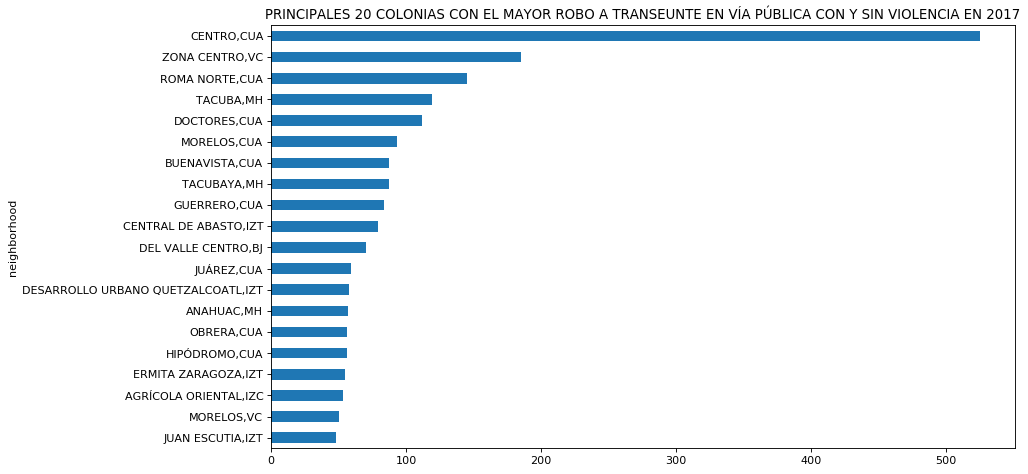

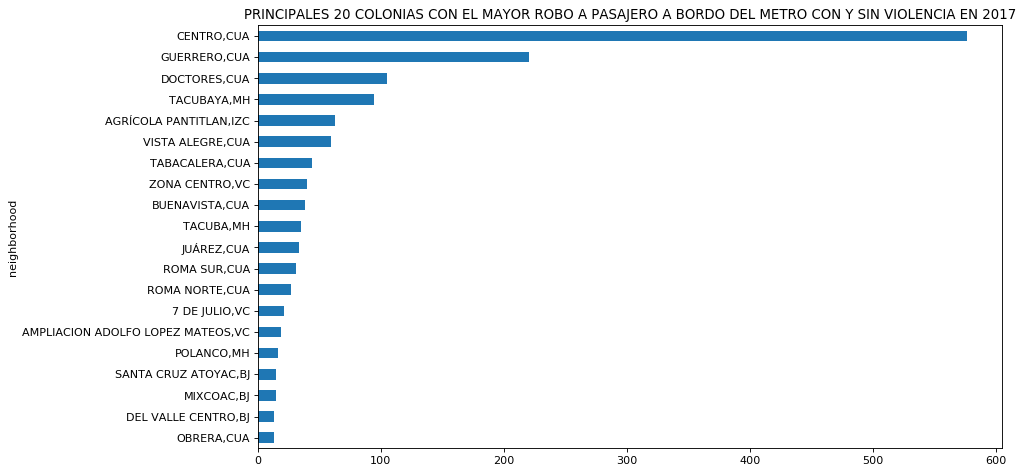

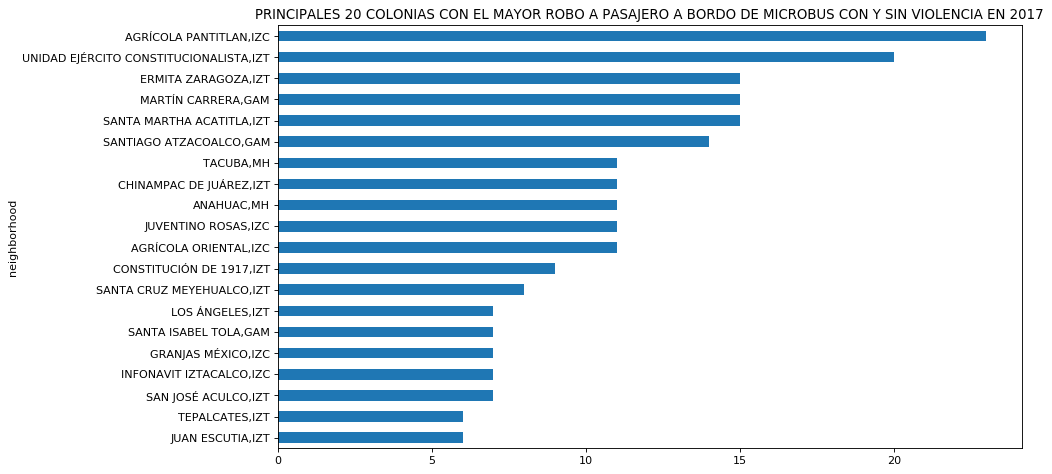

In [32]:
# Top 20 Neighborhood Plots for Violación y Secuestro 2017
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'PRINCIPALES {n} COLONIAS CON EL MAYOR {category} EN 2017')
    top_category_neighborhoods17 = crime_counts17[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods17 = top_category_neighborhoods17.sort_values(ascending=True)
    top_category_neighborhoods17.plot.barh(y=category, rot=0)

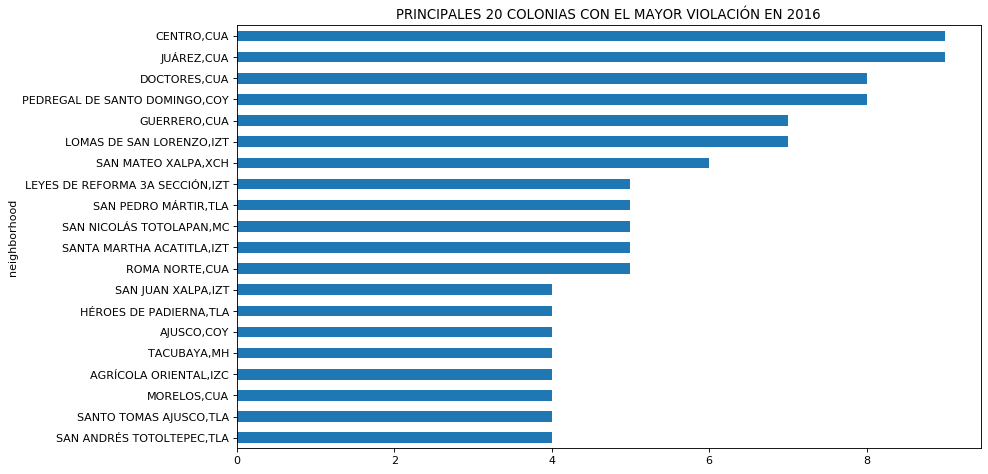

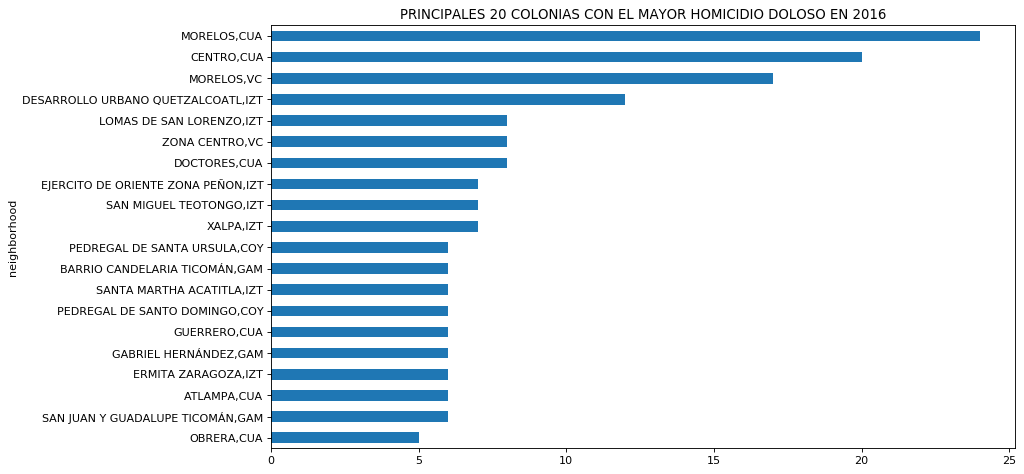

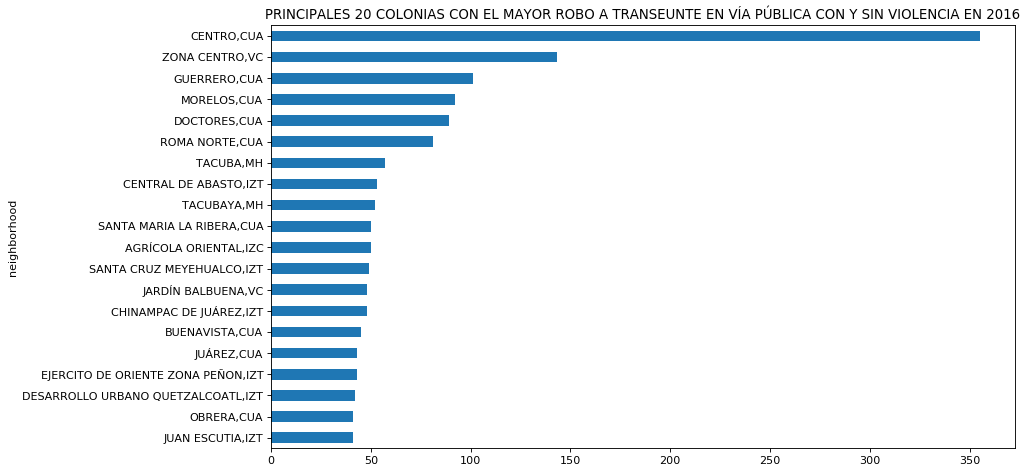

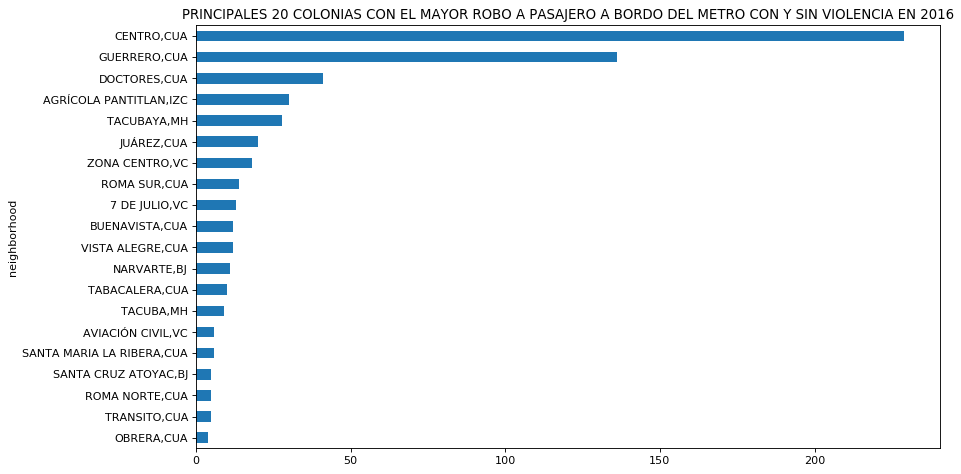

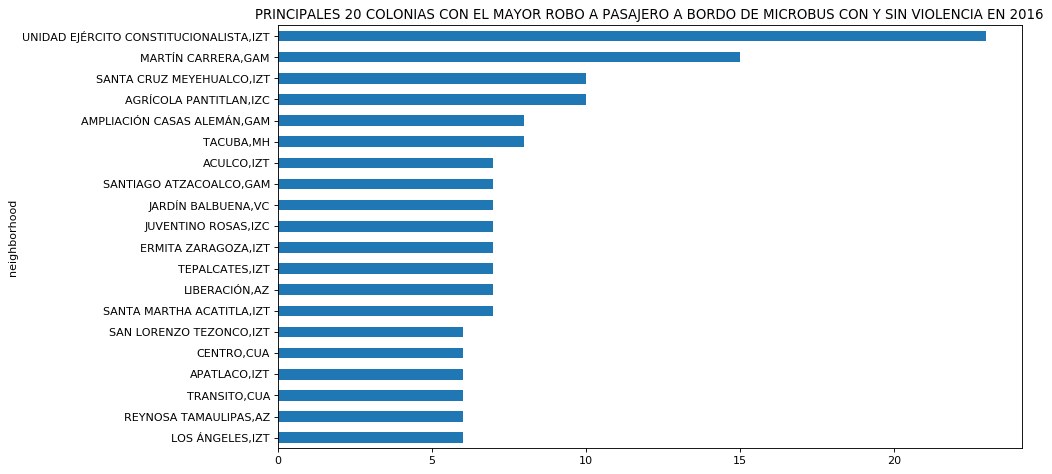

In [33]:
# Top 20 Neighborhood Plots for Violación y Secuestro 2016
for category in plot_categories:
    plt.figure(num=None, figsize=(12, 7), dpi=80, facecolor='w', edgecolor='k')
    plt.title(f'PRINCIPALES {n} COLONIAS CON EL MAYOR {category} EN 2016')
    top_category_neighborhoods16 = crime_counts16[category].sort_values(ascending=False)[0:n]
    top_category_neighborhoods16 = top_category_neighborhoods16.sort_values(ascending=True)
    top_category_neighborhoods16.plot.barh(y=category, rot=0)

#### 3.3 Clustering the Neighborhoods by Number of Crimes / *Agrupando las Colonias por Número de Delitos*

In [34]:
# Create a new dataframe for crime counts
crime_counts19a = crime_counts19
crime_counts19a = crime_counts19a.replace(to_replace=np.nan, value=0).reset_index()
crime_value = crime_counts19a[['neighborhood', 'CRIMENES']].copy()
crime_value['CRIMENES'] = crime_value['CRIMENES'].astype(int)
crime_value.set_index('neighborhood', inplace=True)
crime_value.head()

CRIMENES
neighborhood                 
10 DE ABRIL,MH              6
10 DE MAYO,VC               7
12 DE DICIEMBRE,IZT         5
15 DE AGOSTO,GAM           20
16 DE SEPTIEMBRE,MH         4

In [35]:
# Make a dataframe with CRIMENES 
type = ['CRIMENES']

# For each venue category, determine the percentage of entities in each neighborhood
crime_totals = {}
for category in type:
    crime_totals[category] = crime_value[category].sum()

crime_mean = pd.DataFrame()
for category, total in crime_totals.items():
    crime_mean[category] = crime_value[category].apply(lambda x: x / total)
crime_mean = crime_mean.reindex(sorted(crime_mean.columns), axis=1).reset_index()
crime_mean.head(5)

neighborhood  CRIMENES
0       10 DE ABRIL,MH  0.000205
1        10 DE MAYO,VC  0.000240
2  12 DE DICIEMBRE,IZT  0.000171
3     15 DE AGOSTO,GAM  0.000685
4  16 DE SEPTIEMBRE,MH  0.000137

In [36]:
# Define Clusters en 5
kclusters = 5

crime_grouped_clustering = crime_mean.drop('neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(crime_grouped_clustering)

kmeans.labels_

array([0, 0, 0, ..., 2, 0, 0], dtype=int32)

In [37]:
# Reset Index y2019  Crimes dataframe
crime_counts19 = crime_counts19.reset_index()

In [38]:
# Get new dataframe with all the columns
crime_counts19.insert(1,'Cluster', kmeans.labels_)
clustercolonias = coloniascdmx
clustercolonias = clustercolonias.join(crime_counts19.set_index('neighborhood'), on='neighborhood').dropna(axis=0)

In [40]:
clustercolonias['Cluster'] = clustercolonias['Cluster'].astype(int)
clustercolonias['CRIMENES'] = clustercolonias['CRIMENES'].astype(int)
clustercolonias['VIOLACIÓN'] = clustercolonias['VIOLACIÓN'].astype(int)
clustercolonias['HOMICIDIO DOLOSO'] = clustercolonias['HOMICIDIO DOLOSO'].astype(int)
clustercolonias.head(10)

neighborhood  longitude   latitude  Cluster  \
0                             10 DE ABRIL,MH -99.208339  19.448460        0   
1                              10 DE MAYO,VC -99.117641  19.433161        0   
2                        12 DE DICIEMBRE,IZT -99.100685  19.329177        0   
3                           15 DE AGOSTO,GAM -99.107685  19.484104        0   
4                        16 DE SEPTIEMBRE,MH -99.207518  19.401741        0   
5                              19 DE MAYO,AO -99.253286  19.361737        0   
6               1A AMPLIACIÓN PRESIDENTES,AO -99.221669  19.377717        0   
7                             1A VICTORIA,AO -99.197709  19.387578        0   
8            1ER REACOMODO CORPUS CHRISTI,AO -99.251048  19.358172        0   
9  1RA. AMPLIACIÓN SANTIAGO ACAHUALTEPEC,IZT -99.009991  19.352786        0   

   HOMICIDIO DOLOSO  LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
0                 0                                            0.0   
1                 0                                            0.0   
2                 0                                            0.0   
3                 0                                            1.0   
4                 0                                            0.0   
5                 0                                            0.0   
6                 0                                            0.0   
7                 1                                            0.0   
8                 0                                            0.0   
9                 0                                            0.0   

   ROBO A CASA HABITACIÓN CON VIOLENCIA  \
0                                   0.0   
1                                   0.0   
2                                   0.0   
3                                   0.0   
4                                   0.0   
5                                   0.0   
6                                   0.0   
7                                   0.0   
8                                   0.0   
9                                   0.0   

   ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         
5                                                0.0         
6                                                0.0         
7                                                0.0         
8                                                0.0         
9                                                1.0         

   ROBO A NEGOCIO CON VIOLENCIA  \
0                           0.0   
1                           0.0   
2                           1.0   
3                           1.0   
4                           0.0   
5                           0.0   
6                           7.0   
7                           3.0   
8                           0.0   
9                           1.0   

   ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         
5                                                0.0         
6                                                0.0         
7                                                1.0         
8                                                0.0         
9                                                0.0         

   ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
0                                            0.0   
1                                            0.0   
2        

#### 3.4 Showing the Clusters Results / *Mostrando los Resultados de Grupos*

In [41]:
# Make the results a dataframe to present the clusters
values = clustercolonias.groupby('Cluster')['Cluster'].count()
values

Cluster
0    1149
1      15
2      60
3       1
4     244
Name: Cluster, dtype: int64

In [42]:
# Showing results in Cluster 4
print('This cluster have', values.loc[4],'neighborhoods')
clustercolonias.loc[clustercolonias['Cluster'] == 4, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 244 neighborhoods


neighborhood  HOMICIDIO DOLOSO  \
13             20 DE NOVIEMBRE,VC                 1   
33                  7 DE JULIO,VC                 0   
45     ACUEDUCTO DE GUADALUPE,GAM                 0   
51         ADOLFO LÓPEZ MATEOS,VC                 0   
52       ADOLFO RUIZ CORTINES,COY                 4   
...                           ...               ...   
1697  VILLA GUSTAVO A. MADERO,GAM                 0   
1699    VILLA LÁZARO CÁRDENAS,TLA                 0   
1723                      XOCO,BJ                 1   
1735            ZEDEC SANTA FE,AO                 0   
1743             ZONA ESCOLAR,GAM                 3   

      LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
13                                              0.0   
33                                              0.0   
45                                              1.0   
51                                              0.0   
52                                              2.0   
...                                             ...   
1697                                            0.0   
1699                                            0.0   
1723                                            0.0   
1735                                            0.0   
1743                                            2.0   

      ROBO A CASA HABITACIÓN CON VIOLENCIA  \
13                                     1.0   
33                                     0.0   
45                                     0.0   
51                                     1.0   
52                                     0.0   
...                                    ...   
1697                                   0.0   
1699                                   1.0   
1723                                   0.0   
1735                                   0.0   
1743                                   0.0   

      ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
13                                                  0.0         
33                                                  0.0         
45                                                  0.0         
51                                                  1.0         
52                                                  0.0         
...                                                 ...         
1697                                                2.0         
1699                                                0.0         
1723                                                1.0         
1735                                                5.0         
1743                                                0.0         

      ROBO A NEGOCIO CON VIOLENCIA  \
13                             7.0   
33                             0.0   
45                            11.0   
51                             0.0   
52                             7.0   
...                            ...   
1697                           2.0   
1699                           4.0   
1723                           1.0   
1735                          13.0   
1743                           7.0   

      ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
13                                                  0.0         
33                                                  0.0         
45                                                  0.0         
51                                                  4.0         
52                                                  0.0         
...                                                 ...         
1697                                                0.0         
1699                                                1.0         
1723                                                0.0         
1735                                                0.0         
1743                                                0.0         

      ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
13                                              1.0   
33               

In [43]:
# Showing results in Cluster 3
print('This cluster have', values.loc[3],'neighborhoods')
clustercolonias.loc[clustercolonias['Cluster'] == 3, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 1 neighborhoods


neighborhood  HOMICIDIO DOLOSO  \
332   CENTRO,CUA                12   

     LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
332                                            8.0   

     ROBO A CASA HABITACIÓN CON VIOLENCIA  \
332                                   4.0   

     ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
332                                                6.0         

     ROBO A NEGOCIO CON VIOLENCIA  \
332                          82.0   

     ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
332                                                2.0         

     ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
332                                            5.0   

     ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
332                                              321.0       

     ROBO A REPARTIDOR CON Y SIN VIOLENCIA  \
332                                   43.0   

     ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA  \
332                                              511.0      

     ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA  \
332                                       0.0   

     ROBO DE VEHÍCULO CON Y SIN VIOLENCIA  SECUESTRO  VIOLACIÓN  CRIMENES  
332                                  27.0        5.0         12      1038

In [44]:
# Showing results in Cluster 2
print('This cluster have', values.loc[2],'neighborhoods')
clustercolonias.loc[clustercolonias['Cluster'] == 2, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 60 neighborhoods


neighborhood  HOMICIDIO DOLOSO  \
22         2A. AMPLIACIÓN SANTIAGO ACAHUALTEPEC,IZT                 2   
104                     AMPLIACIÓN CASAS ALEMÁN,GAM                 0   
114             AMPLIACIÓN GABRIEL RAMOS MILLÁN,IZC                 1   
275                                  BUENAVISTA,CUA                 4   
276                                  BUENAVISTA,IZT                 1   
295                     CAMPAMENTO 2 DE OCTUBRE,IZC                 1   
345                         CHINAMPAC DE JUÁREZ,IZT                 6   
370                        CONSTITUCIÓN DE 1917,IZT                 0   
450              EJERCITO DE ORIENTE ZONA PEÑON,IZT                 2   
508                                   EL ROSARIO,AZ                 2   
541                             ERMITA ZARAGOZA,IZT                 2   
543                           ESCANDÓN I SECCIÓN,MH                 0   
600      GABRIEL RAMOS MILLÁN SECCIÓN BRAMADERO,IZC                 0   
633                           GUADALUPE TEPEYAC,GAM                 0   
651                                   HIPÓDROMO,CUA                 2   
680                         INFONAVIT IZTACALCO,IZC                 1   
720                              JARDÍN BALBUENA,VC                 0   
732                                JUAN ESCUTIA,IZT                 2   
853                 LEYES DE REFORMA 3A SECCIÓN,IZT                 1   
859                                  LINDAVISTA,GAM                 0   
890                        LOMAS DE SAN LORENZO,IZT                 8   
948                                 LOS ÁNGELES,IZT                 0   
1009                        MOCTEZUMA 2A SECCIÓN,VC                 2   
1019                                    MORELOS,CUA                16   
1020                                     MORELOS,VC                14   
1060                                     OBRERA,CUA                 3   
1124                  PEDREGAL DE SANTO DOMINGO,COY                 3   
1131                           PENSADOR MEXICANO,VC                 4   
1161                                     POLANCO,MH                 2   
1165                                     POPOTLA,MH                 0   
1169                                PORTALES SUR,BJ                 3   
1247                           REFORMA POLÍTICA,IZT                 7   
1266                      RESIDENCIAL ZACATENCO,GAM                 1   
1287                                   ROMA SUR,CUA                 1   
1306                      SAN ANDRÉS TOTOLTEPEC,TLA                 7   
1331                        SAN FELIPE DE JESÚS,GAM                 6   
1367              SAN JUAN DE ARAGÓN IV SECCIÓN,GAM                 0   
1417                      SAN MIGUEL CHAPULTEPEC,MH                 1   
1419                        SAN MIGUEL TEOTONGO,IZT                 7   
1426                                 SAN MIGUEL,IZT                 1   
1438                      SAN PEDRO DE LOS PINOS,BJ                 0   
1448                                 SAN RAFAEL,CUA                 0   
1478                           SANTA CRUZ ATOYAC,BJ                 0   
1482                      SANTA CRUZ MEYEHUALCO,IZT                 5   
1492                          SANTA ISABEL TOLA,GAM                 2   
1501                      SANTA MARIA LA RIBERA,CUA                 8   
1506                  SANTA MARTHA ACATITLA SUR,IZT                 2   
1507                      SANTA MARTHA ACATITLA,IZT                 4   
1555                                 TABACALERA,CUA                 2   
1575                                 TEPALCATES,IZT                 0   
1581                        TEPEYAC INSURGENTES,GAM                 1   
1626                                   TRANSITO,CUA                 2   
1639         UNIDAD EJÉRCITO CONSTITUCIONALISTA,IZT                 4   
1650                    UNIDAD VICENTE GUERRERO,IZT                 6   
1652    UNIVERSIDAD NACI

In [45]:
# Showing results in Cluster 1
print('This cluster have', values.loc[1],'neighborhoods')
clustercolonias.loc[clustercolonias['Cluster'] == 1, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 15 neighborhoods


neighborhood  HOMICIDIO DOLOSO  \
58                 AGRÍCOLA ORIENTAL,IZC                 4   
59                AGRÍCOLA PANTITLAN,IZC                 2   
145                           ANAHUAC,MH                 4   
324                CENTRAL DE ABASTO,IZT                 7   
428                  DEL VALLE CENTRO,BJ                 2   
432   DESARROLLO URBANO QUETZALCOATL,IZT                 5   
437                         DOCTORES,CUA                 7   
628                   GRANJAS MÉXICO,IZC                 1   
643                         GUERRERO,CUA                 5   
738                           JUÁREZ,CUA                 3   
1033                         NARVARTE,BJ                 2   
1286                      ROMA NORTE,CUA                 0   
1557                           TACUBA,MH                 4   
1558                         TACUBAYA,MH                 1   
1740                      ZONA CENTRO,VC                 6   

      LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
58                                              7.0   
59                                              3.0   
145                                             6.0   
324                                             4.0   
428                                             1.0   
432                                             5.0   
437                                            11.0   
628                                             5.0   
643                                             0.0   
738                                             0.0   
1033                                            0.0   
1286                                            2.0   
1557                                            3.0   
1558                                            0.0   
1740                                            2.0   

      ROBO A CASA HABITACIÓN CON VIOLENCIA  \
58                                     3.0   
59                                     4.0   
145                                    2.0   
324                                    0.0   
428                                    0.0   
432                                    3.0   
437                                    2.0   
628                                    1.0   
643                                    4.0   
738                                    2.0   
1033                                   8.0   
1286                                   2.0   
1557                                   2.0   
1558                                   1.0   
1740                                   0.0   

      ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
58                                                  4.0         
59                                                  6.0         
145                                                 9.0         
324                                                 3.0         
428                                                 9.0         
432                                                 0.0         
437                                                 4.0         
628                                                 1.0         
643                                                 0.0         
738                                                 3.0         
1033                                                2.0         
1286                                               11.0         
1557                                                5.0         
1558                                                2.0         
1740                                                0.0         

      ROBO A NEGOCIO CON VIOLENCIA  \
58                           106.0   
59                            49.0   
145                           62.0   
324                           21.0   
428                           20.0   
432                           49.0   
437                           28.0   
628                           23.0   
643                           11.0

In [46]:
# Showing results in Cluster 0
print('This cluster have', values.loc[0],'neighborhoods')
clustercolonias.loc[clustercolonias['Cluster'] == 0, clustercolonias.columns[[0] + list(range(4, clustercolonias.shape[1]))]]

This cluster have 1149 neighborhoods


neighborhood  HOMICIDIO DOLOSO  \
0                                  10 DE ABRIL,MH                 0   
1                                   10 DE MAYO,VC                 0   
2                             12 DE DICIEMBRE,IZT                 0   
3                                15 DE AGOSTO,GAM                 0   
4                             16 DE SEPTIEMBRE,MH                 0   
...                                           ...               ...   
1742                     ZONA ESCOLAR ORIENTE,GAM                 1   
1745   ZONA URBANA EJIDAL LOS REYES CULHUACAN,IZT                 1   
1747  ZONA URBANA EJIDAL SANTA MARIA TOMATLAN,IZT                 0   
1749                           ÁLVARO OBREGÓN,IZT                 0   
1750                            ÁLVARO OBREGÓN,VC                 0   

      LESIONES DOLOSAS POR DISPARO DE ARMA DE FUEGO  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               1.0   
4                                               0.0   
...                                             ...   
1742                                            0.0   
1745                                            1.0   
1747                                            0.0   
1749                                            0.0   
1750                                            0.0   

      ROBO A CASA HABITACIÓN CON VIOLENCIA  \
0                                      0.0   
1                                      0.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   
...                                    ...   
1742                                   0.0   
1745                                   0.0   
1747                                   1.0   
1749                                   0.0   
1750                                   0.0   

      ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
0                                                   0.0         
1                                                   0.0         
2                                                   0.0         
3                                                   0.0         
4                                                   0.0         
...                                                 ...         
1742                                                1.0         
1745                                                0.0         
1747                                                0.0         
1749                                                1.0         
1750                                                0.0         

      ROBO A NEGOCIO CON VIOLENCIA  \
0                              0.0   
1                              0.0   
2                              1.0   
3                              1.0   
4                              0.0   
...                            ...   
1742                           0.0   
1745                           2.0   
1747                           0.0   
1749                           2.0   
1750                           0.0   

      ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
0                                                   0.0         
1                                                   0.0         
2                                                   0.0         
3                                                   0.0         
4                                                   0.0         
...                                                 ...         
1742                                                0.0         
1745                                                0.0         
1747                                                0.0         
1749                                                0.0         
1750             

# 4. Map with Markers / *Mapa con Marcadores*<a id="6"></a>

#### 4.1 Creating a Map of Neighborhoods clustering by crimes with markers / *Creando un mapa de las colonias agrupadas por delitos con marcadores*

In [48]:
# create map
latitude = 19.4195042636
longitude = -99.1387615628
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, crimes, vio, hom in zip(clustercolonias['latitude'], clustercolonias['longitude'], clustercolonias['neighborhood'],
                                                    clustercolonias['Cluster'], clustercolonias['CRIMENES'], clustercolonias['VIOLACIÓN'], clustercolonias['HOMICIDIO DOLOSO']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + ' Crimenes ' + str(crimes) + ' Violaciones ' + str(vio) + ' Homicidios ' + str(hom), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=1.0).add_to(map_clusters)
       
map_clusters

In [49]:
# Saving the map for document purposes
map_clusters.save('map_clusters.html')

Code created by Data Scientist David Arturo Balcázar Amador on August 2019  
*Código creado por el Científico de Datos David Arturo Balcázar Amador en Agosto de 2019*